This notebook performs all the modeling steps on the combined Airline On-Time Performance, Origin & Destination Survey, and NOAA GHCND data. I first set up the data for modeling and then evaluate four models:

* `LRFlight`, a logistic regression model with only flight schedule features
* `LRWX`, a logistic regression model with only weather features
* `LRAll`, a logistic regression model with flight schedule and weather features
* `RFFlight`, a random forest model with only flight schedule features
* `RFWX`, a random forest model with only weather features
* `RFAll`, a random forest model with flight schedule and weather features

I use these models because for this stage of the project, I am emphasizing interpretability and want to be able to have some sense of which features are contributing to incidence of flight delays.

Baseline, as well as models with mild-to-exhaustive parameter tuning, are evaluated for each of these with respect to recall.

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import math
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

plt.style.use('fivethirtyeight')

Use the 2015-16 data for training/validation and (later on) the 2017 data as the testing/holdout.

In [2]:
with open('aotp_nyc_data_all1516.pkl', 'rb') as picklefile1:
    all_data1516 = pickle.load(picklefile1)

Define functions below to:

* Set up data for modeling
* Split the training set (2015-16 data) into further train/validation sets
* Evaluate the given candidate model (as specified above) and collect training and testing scores

In [3]:
def org_data(df, idx_cols, num_cols, cat_cols, response):
    '''
    This function organizes a dataframe into a smaller dataframe that includes only the response
    variable and features to be evaluated in modeling.
    
    Given:
    df, dataframe 
    idx_cols, index variable columns in df (not to be considered in any model)
    num_cols, numerical variable columns in df
    cat_cols, categorical variable columns in df
    response, response variable column in df
    
    Return:
    all_data, a dataframe including only the response and features incorporated in a given model
    '''
    
    all_cols = response + idx_cols + num_cols + cat_cols
    all_data = df[all_cols]
    all_data = pd.get_dummies(all_data, columns=cat_cols, drop_first=True)
    return all_data

In [4]:
def way_specific_train_test_split(dmat, split, response, to_drop):
    '''
    This function performs a train/validation split on the main "training" set -- this is specific
    to this particular project. The split is conducted on quarters of Year 2017:
    -Train: all of 2015, Validation: all of 2016
    -Train: 2016 + Q1 2015, Valdiation: Q2-4 2016
    -Train: 2016 + Q1-2 2015, Validation: Q3-4 2016
    -Train: 2016 + Q1-3 2015, Validation: Q4 2016
    
    Given:
    df, dataframe
    split, defining the quarter of 2016 to split on
    response, the response variable column in df
    to_drop, columns to drop from df
    
    Return:
    Xtrain, ytrain, Xtest, ytest, the data matrix and response vector for the train and validation sets
    '''
    train_set = dmat[(dmat['Year'] == 2015) | ((dmat['Year'] == 2016) & (dmat['Quarter'] < split))]
    ytrain = train_set[response]
    Xtrain = train_set.drop(to_drop, axis=1)

    test_set = dmat[(dmat['Year'] == 2016) & (dmat['Quarter'] >= split)]
    ytest = test_set[response]
    Xtest = test_set.drop(to_drop, axis=1)
    
    return Xtrain, ytrain, Xtest, ytest

In [5]:
def fit_eval(model, df, idx_cols, num_cols, cat_cols, response):
    '''
    This function sets up data for modeling, splits into train and validation sets iteratively,
    and fits/scores a model (logistic regression or random forest) across those splits. The 
    scoring metric is a modification of F1 score replacing precision with accuracy.
    
    Given:
    model, the model to be evaluated
    df, dataframe 
    idx_cols, index variable columns in df (not to be considered in any model)
    num_cols, numerical variable columns in df
    cat_cols, categorical variable columns in df
    response, response variable column in df
    
    Return:
    best_coefs, the coefficients (or feature importance ratings) of the model in its best split
    train_scores, the training scores for each split
    test_scores, the validation scores for each split
    '''
    datadf = org_data(df, idx_cols, num_cols, cat_cols, response)
    train_scores = []
    test_scores = []
    coefs = []
    for q in range(1,5):
        
        Xtrain, ytrain, Xtest, ytest = way_specific_train_test_split(datadf, q, response, response+idx_cols)
        
        sc = preprocessing.StandardScaler()
        Xtrain[num_cols] = sc.fit_transform(Xtrain[num_cols])        
        
        clf = model.fit(Xtrain, np.ravel(ytrain))      
        ypred = clf.predict(Xtrain)
        
        Xtest[num_cols] = sc.transform(Xtest[num_cols])
        ypred2 = clf.predict(Xtest)
        
        rec_test = metrics.recall_score(ytest, ypred2)
        test_scores.append(rec_test)
        
        del(Xtrain)
        del(ytrain)
        del(Xtest)
        del(ytest)
    
    del(datadf)
    
    return train_scores, test_scores

Define the parts of the main dataframe with all flight schedule and weather data to be used in the model as inputs for the above functions.

In [6]:
response = ['ArrDel15']
idx_cols = ['Year', 'Quarter']
num_cols = ['AirTime', 'BusPassRatio', 'OrigPerf', 'DestPerf']
num_cols_wx = ['ATemp', 'Precip', 'AWind', 'ATempDest', 'PrecipDest', 'AWindDest']
num_cols_all = ['AirTime', 'ATemp', 'Precip', 'AWind', 'ATempDest', 'PrecipDest', 'AWindDest', 'BusPassRatio', 'OrigPerf', 'DestPerf']
cat_cols = ['Month', 'DayOfWeek', 'Origin', 'UniqueCarrier', 'DepTimeBlk', 'ArrTimeBlk']

Run logistic regression for the case with no weather features and the case with weather features. Specify `balanced` for `class_weight` argument because of imbalanced classes. 

Do the same for a random forest classifier. Some manual tuning led to using the specified parameters (max_depth for all generated trees, n_estimators for the number of trees to generate and sample) to fit for all cases.

In [49]:
# Baseline Logistic Regression
lr = LogisticRegression(class_weight='balanced')
lrtrain_fl, lrtest_fl = fit_eval(lr, all_data1516, idx_cols, num_cols, cat_cols, response)
lrtrain_wx, lrtest_wx = fit_eval(lr, all_data1516, idx_cols, num_cols_wx, cat_cols, response)
lrtrain_all, lrtest_all = fit_eval(lr, all_data1516, idx_cols, num_cols_all, cat_cols, response)

In [9]:
# Baseline Random Forest with 100 trees and maximum depth of 3
rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt', max_depth=5, n_estimators=300, class_weight='balanced')
rftrain_fl, rftest_fl = fit_eval(rf, all_data1516, idx_cols, num_cols, cat_cols, response)
rftrain_wx, rftest_wx = fit_eval(rf, all_data1516, idx_cols, num_cols_wx, cat_cols, response)
rftrain_all, rftest_all = fit_eval(rf, all_data1516, idx_cols, num_cols_all, cat_cols, response)

Collect the scores above for each model across all splits into a dataframe to visualize results and do a preliminary model selection.

In [10]:
scores_df = pd.DataFrame(np.array([lrtest_fl, rftest_fl, lrtest_wx, rftest_wx, lrtest_all, rftest_all])).T
scores_df.columns = ['LRFlight', 'RFFlight', 'LRWX', 'RFWX', 'LRFlightWX', 'RFFlightWX']

In [11]:
scores_df

,LRFlight,RFFlight,LRWX,RFWX,LRFlightWX,RFFlightWX
0,0.632578,0.684912,0.639568,0.570340,0.643486,0.577704
1,0.584093,0.690382,0.608113,0.500608,0.617158,0.561468
2,0.587957,0.705678,0.615371,0.558083,0.631103,0.579819
3,0.503463,0.697661,0.571755,0.535409,0.588950,0.579007


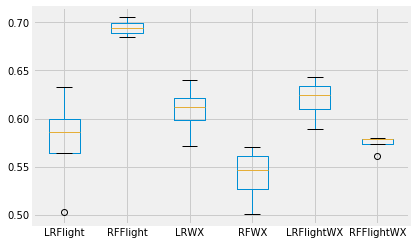

In [12]:
# Comparison of baseline models
scores_df.boxplot()

Here I create a preliminary "grid" and function for a "grid search" to evaluate the different random forest models.

In [13]:
# "Grid" for RF models
estimators = [100, 300, 500, 1000]
depth = [3, 5, 10]

In [16]:
def rf_grid(estimators, depth, df, idx_cols, num_cols, cat_cols, response):
    
    best_test = 0
    best_depth = None
    best_est = None
    best_test_scores = []
    
    for x in estimators:
        for y in depth:
            rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt', max_depth=y, n_estimators=x, random_state=1, class_weight='balanced')
            train_scores, test_scores = fit_eval(rf, df, idx_cols, num_cols, cat_cols, response)
            mean_test = np.mean(test_scores)
            if mean_test > best_test:
                best_test = mean_test
                best_est = x
                best_depth = y
                best_test_scores = test_scores
            print(x,y)
    return best_est, best_depth, best_test_scores

Best parameters for RF with only flight features (prelim)

In [17]:
best_est_fl, best_depth_fl, best_test_scores_fl = rf_grid(estimators, depth, all_data1516, idx_cols, num_cols, cat_cols, response)

100 3
100 5
100 10
300 3
300 5
300 10
500 3
500 5
500 10
1000 3
1000 5
1000 10


In [18]:
print(best_est_fl)
print(best_depth_fl)
print(best_test_scores_fl)

100
3
[0.7136978479592038, 0.7266139657444005, 0.7669439421338156, 0.7089886724798304]


Best parameters for RF with only weather features

In [19]:
best_est_wx, best_depth_wx, best_test_scores_wx = rf_grid(estimators, depth, all_data1516, idx_cols, num_cols_wx, cat_cols, response)

100 3
100 5
100 10
300 3
300 5
300 10
500 3
500 5
500 10
1000 3
1000 5
1000 10


In [20]:
print(best_est_wx)
print(best_depth_wx)
print(best_test_scores_wx)

300
3
[0.5471066569532773, 0.5323553258335867, 0.5502350813743219, 0.5579822345367126]


Best parameters for RF with all features

In [21]:
best_est_all, best_depth_all, best_test_scores_all = rf_grid(estimators, depth, all_data1516, idx_cols, num_cols_all, cat_cols, response)

100 3
100 5
100 10
300 3
300 5
300 10
500 3
500 5
500 10
1000 3
1000 5
1000 10


In [22]:
print(best_est_all)
print(best_depth_all)
print(best_test_scores_all)

1000
5
[0.5801256177518754, 0.5659268267963921, 0.5792766726943942, 0.5899274712737348]


Now let's create a preliminary "grid" and function for a "grid search" to evaluate the different logistic regression models.

In [23]:
# "Grid" for LR models
pen = ['l1', 'l2']
Cs = [.001, .01, .1, .5]

In [65]:
def lr_grid(pen, Cs, df, idx_cols, num_cols, cat_cols, response):
    
    best_test = 0
    best_pen = None
    best_C = None
    best_test_scores = []
    
    for p in pen:
        for c in Cs:
            lr = LogisticRegression(class_weight='balanced', penalty=p, C=c, n_jobs=-1, solver='saga')
            train_scores, test_scores = fit_eval(lr, df, idx_cols, num_cols, cat_cols, response)
            mean_test = np.mean(test_scores)
            if mean_test > best_test:
                best_test = mean_test
                best_pen = p
                best_C = c
                best_test_scores = test_scores
    return best_pen, best_C, best_test_scores

Best parameters for logistic regression with only flight features

In [ ]:
best_pen_fl, best_c_fl, best_test_scores_fl_lr = lr_grid(pen, Cs, all_data1516, idx_cols, num_cols, cat_cols, response)

In [68]:
print(best_pen_fl)
print(best_c_fl)
print(best_test_scores_fl_lr)

l1
0.001
[0.6272027407509501, 0.6128002432350258, 0.618372513562387, 0.5335343492787874]


Best paramaters for logistic regression with only weather features

In [34]:
best_pen_wx, best_c_wx, best_test_scores_wx_lr = lr_grid(pen, Cs, all_data1516, idx_cols, num_cols_wx, cat_cols, response)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [35]:
print(best_pen_wx)
print(best_c_wx)
print(best_test_scores_wx_lr)

l2
0.5
[0.6394888656992656, 0.6080115536637276, 0.6149728752260398, 0.5718360361828702]


Best parameters for logisitc regression with all features

In [39]:
best_pen_all, best_c_all, best_test_scores_all_lr = lr_grid(pen, Cs, all_data1516, idx_cols, num_cols_all, cat_cols, response)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [40]:
print(best_pen_all)
print(best_c_all)
print(best_test_scores_all_lr)

l2
0.5
[0.6434267262596232, 0.6170315192054322, 0.6311392405063291, 0.5889495558634178]


For the random forest model with only flight features, which was selected as best performing for recall, do a more "exhaustive grid search"

In [43]:
# Another "grid" for RF model with only flight schedule features
estimators = np.arange(100, 1100, 100)
depth = np.arange(3, 13, 1)
best_est_fl, best_depth_fl, best_test_scores_fl = rf_grid(estimators, depth, all_data1516, idx_cols, num_cols, cat_cols, response)

100 3
100 4
100 5
100 6
100 7
100 8
100 9
100 10
100 11
100 12
200 3
200 4
200 5
200 6
200 7
200 8
200 9
200 10
200 11
200 12
300 3
300 4
300 5
300 6
300 7
300 8
300 9
300 10
300 11
300 12
400 3
400 4
400 5
400 6
400 7
400 8
400 9
400 10
400 11
400 12
500 3
500 4
500 5
500 6
500 7
500 8
500 9
500 10
500 11
500 12
600 3
600 4
600 5
600 6
600 7
600 8
600 9
600 10
600 11
600 12
700 3
700 4
700 5
700 6
700 7
700 8
700 9
700 10
700 11
700 12
800 3
800 4
800 5
800 6
800 7
800 8
800 9
800 10
800 11
800 12
900 3
900 4
900 5
900 6
900 7
900 8
900 9
900 10
900 11
900 12
1000 3
1000 4
1000 5
1000 6
1000 7
1000 8
1000 9
1000 10
1000 11
1000 12


In [44]:
print(best_est_fl)
print(best_depth_fl)
print(best_test_scores_fl)

200
3
[0.7252357794010514, 0.7292490118577075, 0.7640867992766727, 0.7144487001874338]


Another model comparison just for kicks

In [73]:
scores_df = pd.DataFrame(np.array([lrtest_fl, best_test_scores_fl_lr, 
                                   rftest_fl, best_test_scores_fl, 
                                   lrtest_wx, best_test_scores_wx_lr, 
                                   rftest_wx, best_test_scores_wx, 
                                   lrtest_all, best_test_scores_all_lr, 
                                   rftest_all, best_test_scores_all])).T
scores_df.columns = ['LRFlight', 'LRFlightOpt', 'RFFlight', 'RFFlightOpt', 'LRWX', 'LRWXOpt', 'RFWX', 'RFWXOpt', 
                     'LRFlightWX', 'LRFlightWXOpt', 'RFFlightWX', 'RFFlightWXOpt']

In [74]:
scores_df

,LRFlight,LRFlightOpt,RFFlight,RFFlightOpt,LRWX,LRWXOpt,RFWX,RFWXOpt,LRFlightWX,LRFlightWXOpt,RFFlightWX,RFFlightWXOpt
0,0.632578,0.627203,0.684912,0.725236,0.639568,0.639489,0.570340,0.547107,0.643486,0.643427,0.577704,0.580126
1,0.584093,0.612800,0.690382,0.729249,0.608113,0.608012,0.500608,0.532355,0.617158,0.617032,0.561468,0.565927
2,0.587957,0.618373,0.705678,0.764087,0.615371,0.614973,0.558083,0.550235,0.631103,0.631139,0.579819,0.579277
3,0.503463,0.533534,0.697661,0.714449,0.571755,0.571836,0.535409,0.557982,0.588950,0.588950,0.579007,0.589927


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Text xticklabel objects>)

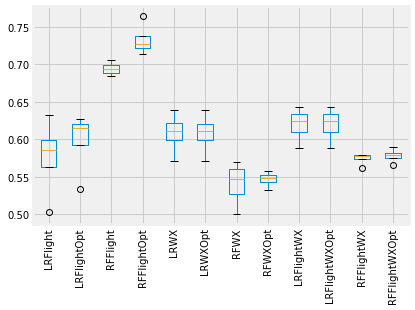

In [77]:
scores_df.boxplot()
plt.xticks(rotation=90)

Now fit the "optimized" RFFlightOpt model on all the training data and evaluate on holdout.

In [33]:
rf2 = RandomForestClassifier(n_jobs=-1, max_features='sqrt', max_depth=best_depth_fl, n_estimators=best_est_fl, class_weight='balanced', random_state=1)

In [34]:
data_mod = org_data(all_data1516, idx_cols, num_cols, cat_cols, response)

In [35]:
drop_cols = idx_cols + response

In [36]:
sc = preprocessing.StandardScaler()
X = data_mod.drop(drop_cols, axis=1)
Y = data_mod[response]

In [37]:
X[num_cols] = sc.fit_transform(X[num_cols])    
clf = rf2.fit(X, np.ravel(Y))      
ypred = clf.predict(X)

Evaluating on holdout for recall

In [38]:
with open('aotp_nyc_data_all17.pkl', 'rb') as picklefile2:
    all_data17 = pickle.load(picklefile2)

In [39]:
data_mod_holdout = org_data(all_data17, idx_cols, num_cols, cat_cols, response)
Xholdout = data_mod_holdout.drop(drop_cols, axis=1)
Yholdout = data_mod_holdout[response]

In [40]:
Xholdout[num_cols] = sc.transform(Xholdout[num_cols])
ypred2 = clf.predict(Xholdout)

In [41]:
metrics.recall_score(Yholdout, ypred2)

0.7397824715097071

Performance appears to do slightly better on the holdout set, but not by a large amount, at least relative to what was observed in the train/validation step. There may be some overfitting here but nothing substantial. Let's now construct and look at the confusion matrix from applying this classifier to the 2015-16 flight data.

In [42]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm=confusion_matrix(Yholdout, ypred2, labels=None)

In [43]:
import itertools
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Blues):
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.xticks(range(0,2), ['Not Delayed', 'Delayed'])
    plt.yticks(range(0,2), ['Not Delayed', 'Delayed'])
    plt.title('RFFlight Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

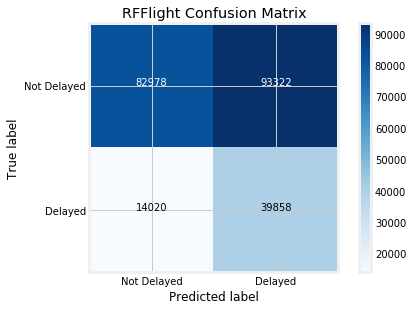

In [44]:
plot_confusion_matrix(cm)

The model performs well in correctly identifying flights that are delayed, compared to the same task for not delayed flights. About half of the flights which were not actually delayed are misclassified, and there is a rather large number of false positives (so precision is not quite what it needs to be).

In [45]:
feat_imp = np.ravel(rf2.feature_importances_)
features = Xholdout.columns.values
zipped = zip(features, feat_imp)
feat_imp_sort = sorted(list(zipped), key=lambda tup: abs(tup[1]), reverse=True)[:10]

([<matplotlib.axis.YTick at 0x1aac2b2f98>,
 <a list of 10 Text yticklabel objects>)

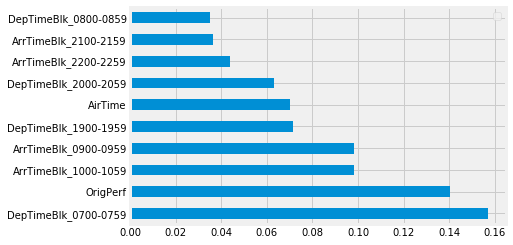

In [46]:
feat_imp_df = pd.DataFrame.from_records(feat_imp_sort)
feat_imp_df.plot.barh()
plt.legend([])
plt.yticks(range(0, len(feat_imp_df)), feat_imp_df[0])

In [47]:
feat_imp_sort[:10]

[('DepTimeBlk_0700-0759', 0.1572301431240016),
 ('OrigPerf', 0.14035572206718627),
 ('ArrTimeBlk_1000-1059', 0.09831751628112677),
 ('ArrTimeBlk_0900-0959', 0.09829700646151966),
 ('DepTimeBlk_1900-1959', 0.07156296443663702),
 ('AirTime', 0.0699639068048941),
 ('DepTimeBlk_2000-2059', 0.06319853155284627),
 ('ArrTimeBlk_2200-2259', 0.04382100513168686),
 ('ArrTimeBlk_2100-2159', 0.03634388186106931),
 ('DepTimeBlk_0800-0859', 0.03482302699231555)]

Of the 10 most important features identified, 8 are "time of day" variables, particularly include early morning and evening scheduled departure times and late morning and late night arrival times. This seems sensible given that these time periods will generally have lots of volume being associated with travel for business. 

Notably `OrigPerf`, the percentage of capacity of scheduled hourly volume at origin airports, is the second most important feature. This latter point indicate that scheduled volume at the three NYC airports, especially during times of the day when many passengers are flying (aligned with business hours) can impact the incidence of large arrival delays. 